##  Piza Nava Vladimir - 111-494


## Laboratorio 2 

## Link al repositorio:

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

### Resumen de pasos:
1. **Importaciones**: Se importan módulos de PyTorch, transformaciones de imágenes y herramientas para manejo de datos.
2. **Configuración de DirectML**: Se configura DirectML como dispositivo para ejecutar operaciones en la GPU de AMD, si está disponible.
3. **Impresión de dispositivo**: Se imprime el dispositivo que se está utilizando (DirectML).


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import time
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch_directml  # Importar DirectML

# Configurar DirectML
device = torch_directml.device()
print(f"Usando DirectML en: {device}")

Usando DirectML en: privateuseone:0


### Explicación General del Código

Este código prepara un conjunto de datos de imágenes de flores para su uso en un modelo de aprendizaje automático.

1. **Transformaciones de Imágenes:** Redimensiona las imágenes a 64x64 píxeles, las convierte a tensores y las normaliza para facilitar el entrenamiento.

2. **Carga y Preprocesamiento:** Carga un archivo CSV con rutas de imágenes y etiquetas, y convierte las etiquetas de texto a valores numéricos.

3. **División del Dataset:** Divide el conjunto de datos en dos partes: una para entrenamiento y otra para validación.

4. **Dataset Personalizado:** Define una clase para cargar imágenes y aplicar transformaciones.

5. **Dataloaders:** Utiliza Dataloaders para gestionar la distribución de los datos en lotes y su carga eficiente durante el entrenamiento.

Este proceso prepara los datos para entrenar un modelo de clasificación de imágenes en PyTorch.

In [2]:
# Transformaciones simples para acelerar el proceso
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona las imágenes a 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar CSV con rutas y etiquetas
df = pd.read_csv('dataset_flores.csv')

# Convertir etiquetas a números
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Dividir en entrenamiento y validación
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

class FlowerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(image_path).convert("RGB")  # Aquí se usa Image para abrir la imagen
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Cargar datasets
dataset = {
    'train': FlowerDataset(train_df, transform=transform),
    'val': FlowerDataset(val_df, transform=transform)
}

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=0, pin_memory=True),
    'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
}

## Explicación General del Código

### `build_model`
Crea un modelo de **perceptrón multicapa (MLP)** en PyTorch con:
1. **Capa de entrada**: Aplana la imagen para que pase a las capas lineales.
2. **Capas ocultas**: Dos capas lineales con activación ReLU, normalización y dropout (para prevenir sobreajuste).
3. **Capa de salida**: Predice la clase con un número de unidades igual a las clases del dataset.
4. El modelo se transfiere al dispositivo con tipo de dato `float32`.

### `EarlyStopping`
La clase **early stopping** detiene el entrenamiento si la pérdida de validación no mejora después de un número de épocas (definido por `patience`), ayudando a prevenir sobreajuste y ahorrar tiempo de cómputo.

### Resumen:
- **MLP**: Red neuronal con capas lineales y regularización.
- **Early Stopping**: Detiene el entrenamiento si no hay mejora en la pérdida.

In [3]:
def build_model(input_size=64*64*3, hidden_size=128, output_size=len(label_mapping), dropout=0.5):
    return nn.Sequential(
        nn.Flatten(),  # Aplana la imagen para pasarla a la capa Linear
        nn.Linear(input_size, hidden_size, dtype=torch.float32),
        nn.BatchNorm1d(hidden_size, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_size, 50, dtype=torch.float32),
        nn.BatchNorm1d(50, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(50, output_size, dtype=torch.float32)
    ).to(device, dtype=torch.float32)

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience  # Número de épocas sin mejora antes de detenerse
        self.delta = delta  # Mínima mejora en la pérdida para ser considerada una mejora
        self.best_loss = np.inf  # La mejor pérdida observada
        self.counter = 0  # Contador de épocas sin mejora
        self.stop_training = False  # Bandera para detener el entrenamiento

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:  # Si la pérdida mejora
            self.best_loss = val_loss
            self.counter = 0  # Resetea el contador
        else:
            self.counter += 1  # Incrementa el contador

        if self.counter >= self.patience:  # Si supera el número de épocas sin mejora
            self.stop_training = True
            print("⏸️ Early stopping activado: No hubo mejora después de", self.patience, "épocas.")

# Explicación del Código para Entrenamiento con Early Stopping y Checkpoints

Este código entrena un modelo de red neuronal en PyTorch, utilizando **Early Stopping**, **Checkpoints** y barras de progreso con **tqdm**.

## Función Principal: `train_model_with_early_stopping`

### Parámetros

- **model**: El modelo a entrenar.
- **dataloader**: Contiene los conjuntos de datos de entrenamiento y validación.
- **epochs**: Número de épocas de entrenamiento.
- **log_each**: Frecuencia para mostrar los resultados del entrenamiento.
- **checkpoint_interval**: Intervalo para guardar checkpoints del modelo.
- **patience**: Número de épocas sin mejora en la validación antes de detener el entrenamiento (Early Stopping).

### Funcionamiento

1. **Inicialización**: 
   - Se define la **función de pérdida** (`CrossEntropyLoss`) y el **optimizador** (Adam).
   
2. **Entrenamiento**:
   - Durante cada época, el modelo entrena usando lotes de datos, actualizando los pesos con el optimizador.
   - **tqdm** muestra el progreso de cada época.

3. **Evaluación**:
   - Después de cada época, se evalúa el modelo con el conjunto de validación, calculando la precisión y la pérdida.

4. **Guardado del Mejor Modelo**:
   - Si la precisión en validación mejora, los pesos del modelo se guardan como el mejor modelo.

5. **Checkpoint**:
   - Se guardan checkpoints cada `checkpoint_interval` épocas.

6. **Early Stopping**:
   - Si no hay mejora en la pérdida de validación, el entrenamiento se detiene antes de completar todas las épocas.

### Resumen

El código entrena el modelo y, durante el proceso, evalúa su rendimiento en validación, guarda el mejor modelo, y usa Early Stopping para evitar sobreajuste. También se guardan checkpoints periódicos.

In [17]:
import time
import torch.optim as optim
from tqdm import tqdm  # Importamos tqdm

def train_model_with_early_stopping(model, dataloader, epochs=15, log_each=5, checkpoint_interval=5, patience=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    early_stopping = EarlyStopping(patience=patience)  # Inicializar EarlyStopping
    best_model_wts = model.state_dict()  # Para guardar el mejor modelo
    best_val_acc = 0.0  # Para comparar la precisión de validación

    # Bucle de épocas con tqdm
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        start_time = time.time()

        # Entrenamiento con tqdm para lotes (batches)
        with tqdm(total=len(dataloader['train']), desc=f"Epoch {epoch}/{epochs} | Training", ncols=100) as pbar:
            for batch_idx, (images, labels) in enumerate(dataloader['train']):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)

                # Actualiza la barra de progreso de los lotes
                pbar.set_postfix(loss=loss.item(), accuracy=correct / total)
                pbar.update(1)

        train_acc = correct / total
        elapsed_time = time.time() - start_time
        # Mostramos solo la información de la época
        print(f"Epoch {epoch}/{epochs} | Training: {pbar.n / len(dataloader['train']):.0%}| {pbar.n}/{len(dataloader['train'])} "
              f"[{elapsed_time:.2f}s, accuracy={train_acc:.3f}, loss={total_loss/len(dataloader['train']):.3f}]")

        # Evaluación en el conjunto de validación (sin barra de progreso en validación)
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in dataloader['val']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(dataloader['val'])
        val_acc = val_correct / val_total
        print(f"🔵 Epoch {epoch}/{epochs} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Guardar el mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()  # Guardar los pesos del mejor modelo
            torch.save(model.state_dict(), "best_model_3.pth")  # Guardar como best_model_3.pth
            print(f"🌟 Nuevo mejor modelo guardado como best_model_3.pth con Val Acc: {best_val_acc:.4f}")

        # Checkpoint
        if epoch % checkpoint_interval == 0:
            checkpoint_path = f"checkpoints/mlp_epoch_{epoch}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Checkpoint guardado en: {checkpoint_path}")

        # Llamar a EarlyStopping
        early_stopping(val_loss)
        if early_stopping.stop_training:
            break  # Detener el entrenamiento si no hay mejora

    # Cargar el mejor modelo
    model.load_state_dict(best_model_wts)
    return model

# Entrenamiento con Early Stopping y Checkpoints

Este código entrena un modelo de red neuronal con las siguientes características:

1. **Creación del Modelo**: Se usa `build_model()` para definir la arquitectura.
2. **Entrenamiento**: Se entrena con la función `train_model_with_early_stopping` que incluye:
   - **`epochs=100`**: Número de épocas.
   - **`log_each=5`**: Frecuencia de logs.
   - **`checkpoint_interval=20`**: Guardado de checkpoints cada 20 épocas.
   - **`patience=5`**: Early stopping si no hay mejora tras 5 épocas.

Este enfoque optimiza el entrenamiento evitando el sobreajuste y guardando modelos periódicamente.

In [18]:
# Crear el modelo
model = build_model()

# Entrenar el modelo con early stopping, checkpoints y exportación
history = train_model_with_early_stopping(
    model, 
    dataloader, 
    epochs=15,  # Número total de épocas (puedes ajustarlo)
    log_each=5, 
    checkpoint_interval=5, 
    patience=2  # Detener si no hay mejora después de 10 épocas
)

Epoch 1/15 | Training: 100%|██████████| 157/157 [03:30<00:00,  1.34s/it, accuracy=0.707, loss=0.529]


Epoch 1/15 | Training: 100%| 157/157 [210.24s, accuracy=0.707, loss=0.836]
🔵 Epoch 1/15 | Val Loss: 0.4312 | Val Acc: 0.8576
🌟 Nuevo mejor modelo guardado como best_model_3.pth con Val Acc: 0.8576


Epoch 2/15 | Training: 100%|██████████| 157/157 [03:30<00:00,  1.34s/it, accuracy=0.823, loss=0.527]


Epoch 2/15 | Training: 100%| 157/157 [210.04s, accuracy=0.823, loss=0.518]
🔵 Epoch 2/15 | Val Loss: 0.3157 | Val Acc: 0.8910
🌟 Nuevo mejor modelo guardado como best_model_3.pth con Val Acc: 0.8910


Epoch 3/15 | Training: 100%|██████████| 157/157 [03:25<00:00,  1.31s/it, accuracy=0.851, loss=0.511]


Epoch 3/15 | Training: 100%| 157/157 [205.77s, accuracy=0.851, loss=0.439]
🔵 Epoch 3/15 | Val Loss: 0.2782 | Val Acc: 0.9070
🌟 Nuevo mejor modelo guardado como best_model_3.pth con Val Acc: 0.9070


Epoch 4/15 | Training: 100%|██████████| 157/157 [03:28<00:00,  1.33s/it, accuracy=0.864, loss=0.263]


Epoch 4/15 | Training: 100%| 157/157 [208.06s, accuracy=0.864, loss=0.402]
🔵 Epoch 4/15 | Val Loss: 0.2550 | Val Acc: 0.9113
🌟 Nuevo mejor modelo guardado como best_model_3.pth con Val Acc: 0.9113


Epoch 5/15 | Training: 100%|██████████| 157/157 [03:28<00:00,  1.33s/it, accuracy=0.877, loss=0.335]


Epoch 5/15 | Training: 100%| 157/157 [208.78s, accuracy=0.877, loss=0.367]
🔵 Epoch 5/15 | Val Loss: 0.2375 | Val Acc: 0.9180
🌟 Nuevo mejor modelo guardado como best_model_3.pth con Val Acc: 0.9180


RuntimeError: Parent directory checkpoints does not exist.

### Explicación del código

La función `cargar_y_evaluar_modelo` carga un modelo previamente entrenado y lo evalúa en un conjunto de validación:

1. **Cargar el modelo:** Se cargan los pesos del modelo guardado con `model.load_state_dict`.
2. **Evaluación:** 
   - El modelo se evalúa sobre el conjunto de validación (`val_loader`).
   - Se calcula la pérdida y precisión por cada lote.
   - La precisión se calcula como el porcentaje de predicciones correctas.
3. **Resultado:** Retorna la precisión y la pérdida promedio.

#### Uso:
- Se crea un modelo con `build_model`, luego se evalúa con la función, pasando el modelo, los datos de validación, la función de pérdida y el dispositivo.

El resultado son la precisión y pérdida promedio del modelo en el conjunto de validación.

In [21]:
def cargar_y_evaluar_modelo(model, model_path, val_loader, criterion, device):
    # Cargar el modelo y sus pesos
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Modo evaluación
    
    # Evaluación del modelo
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)

    print(f'Precisión: {accuracy:.2f}% - Pérdida Promedio: {avg_loss:.4f}')
    return accuracy, avg_loss

# Cargar el modelo y evaluarlo
model = build_model(input_size=64*64*3, hidden_size=128, output_size=len(label_mapping), dropout=0.5).to(device)
accuracy, loss = cargar_y_evaluar_modelo(model, "best_model_3.pth", dataloader['val'], nn.CrossEntropyLoss(), device)

C:\Users\vladi\AppData\Local\Temp\ipykernel_27776\3866792858.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Precisión: 91.80% - Pérdida Promedio: 0.2375


### Explicación del código

Este código selecciona una imagen aleatoria de un CSV, la predice con un modelo entrenado, y muestra la imagen junto con su predicción y clase real.

1. **Lista de clases:** Se define una lista `class_names` con las clases de las flores (como "astromelia", "cartucho", etc.).
   
2. **Función `elegir_imagen_aleatoria`:** 
   - Lee el archivo CSV con las rutas y clases de las imágenes.
   - Selecciona aleatoriamente una fila (imagen) y retorna su ruta y clase.

3. **Función `predecir_imagen`:**
   - Carga una imagen, la transforma para adaptarse al modelo, y la pasa por él para hacer la predicción.
   - La clase predicha se convierte en su nombre usando `class_names`.

4. **Cargar y evaluar el modelo:**
   - Se carga un modelo preentrenado desde el archivo `"best_model_3.pth"`.
   - La imagen aleatoria seleccionada se pasa al modelo para obtener una predicción.
   
5. **Visualización:**
   - Se muestra la imagen junto con la predicción del modelo y la clase real.

#### Resultado:
El código predice la clase de una imagen aleatoria y muestra la imagen con su predicción y clase real en un gráfico.

C:\Users\vladi\AppData\Local\Temp\ipykernel_27776\2747038701.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_3.pth", map_lo

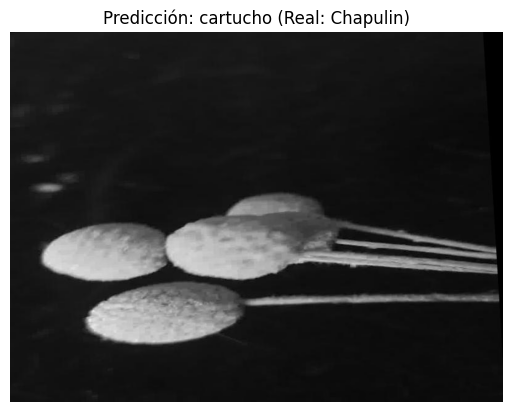

In [32]:
import matplotlib.pyplot as plt

# Lista de clases
class_names = ["astromelia", "cartucho", "chapulin", "lirio", "obispo"]

def elegir_imagen_aleatoria(csv_path="dataset_flores.csv"):
    """Selecciona aleatoriamente una imagen desde un CSV con rutas y clases."""
    df = pd.read_csv(csv_path)
    
    if df.empty:
        return None, None
    
    fila = df.sample(n=1).iloc[0]  # Seleccionar una fila aleatoria
    return fila["image_path"], fila["label"]

def predecir_imagen(model, image_path, class_names, device):
    """Carga una imagen, la pasa por el modelo y devuelve la predicción."""
    image = Image.open(image_path).convert("RGB")  # Cargar la imagen
    image_tensor = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    prediccion = class_names[predicted.item()]  # Convertir índice a nombre de clase
    return image, prediccion

# Cargar modelo guardado
model = build_model(input_size=64*64*3, hidden_size=128, output_size=len(class_names), dropout=0.5).to(device)
model.load_state_dict(torch.load("best_model_3.pth", map_location=device))
model.eval()

# Predecir una imagen aleatoria desde el CSV
image_path, clase_real = elegir_imagen_aleatoria()
if image_path:
    image, prediccion = predecir_imagen(model, image_path, class_names, device)

    # Mostrar la imagen con su predicción y clase real
    plt.imshow(image)
    plt.title(f'Predicción: {prediccion} (Real: {clase_real})')
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes en el CSV.")